# ✈️ JFK Airport Weather Oracle: Volatility & Risk Analysis

## Executive Summary
This project implements a machine learning system to predict daily temperature extremes (TMAX/TMIN) with confidence intervals at JFK International Airport. 

**Methodology:**
* **Model:** XGBoost Quantile Regression (predicting 5th, 50th, and 95th percentiles).
* **Goal:** Generate a dynamic **"Safety Tunnel"** (Confidence Interval) to manage the higher weather volatility observed in winter months.
* **Optimization:** Hyperparameters tuned via Optuna to minimize Mean Absolute Error (MAE).

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import optuna
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import RidgeCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# ==============================================================================
# LOAD & CLEAN DATA
# ==============================================================================
print("Loading and cleaning data...")
df = pd.read_csv("JFK Airport Weather Data.csv", parse_dates=['DATE'])
df = df[df['NAME'].str.contains('JFK')].copy().sort_values('DATE')

# Select useful columns
useful_cols = [
    'DATE', 'TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', # Core
    'AWND', 'WDF2',                                 # Wind
    'WT01', 'WT03', 'WT08', 'WT18'                  # Fog, Thunder, Haze, Snow
]
df = df[useful_cols].copy()

# Fix numeric columns
cols_to_numeric = ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Basic fill for core weather (persistence)
df[cols_to_numeric] = df[cols_to_numeric].ffill().bfill()

Loading and cleaning data...


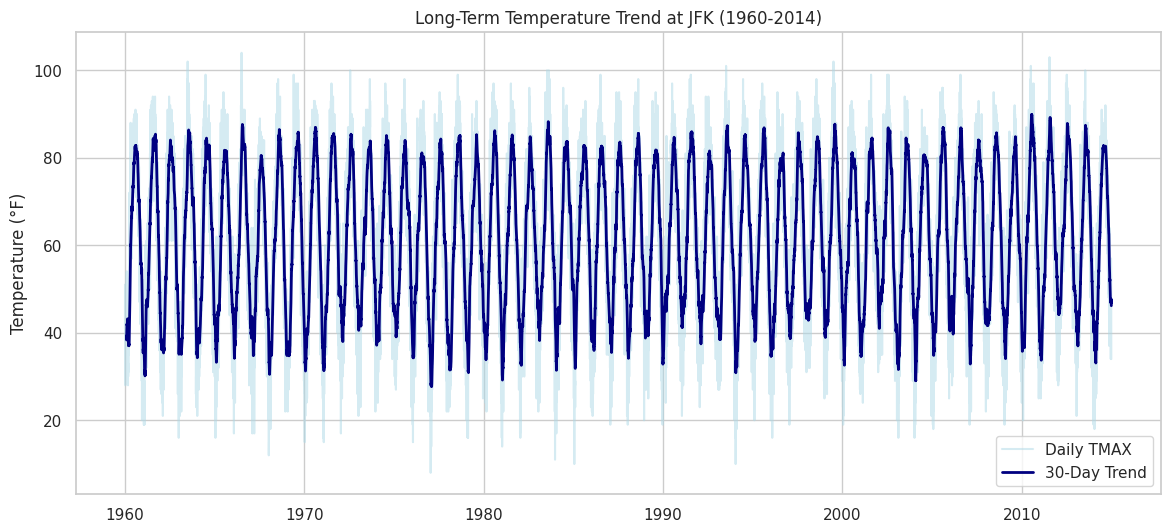

In [4]:
# Set the visual style
sns.set(style="whitegrid")

# This smooths out the daily noise so we can see the "climate"
rolling_mean = df['TMAX'].rolling(window=30).mean()

plt.figure(figsize=(14, 6))

# Plot 1: Raw Daily Data (Light and noisy)
plt.plot(df['DATE'], df['TMAX'], label='Daily TMAX', color='lightblue', alpha=0.5)

# Plot 2: The Trend (Smooth)
plt.plot(df['DATE'], rolling_mean, label='30-Day Trend', color='navy', linewidth=2)

plt.title('Long-Term Temperature Trend at JFK (1960-2014)')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.show()

## 1.1 Exploratory Data Analysis & Strategy

### 🚩 Data Limitations & Constraints
* **Volume:** The dataset is of reasonable size for statistical learning but is insufficient for state-of-the-art Deep Learning models (transformers/LSTMs).
* **Sparsity:** Several key columns (Wind, Sunshine) are missing in ~50% of the historical record. Specific weather event flags (`WTxx`) are extremely sparse, requiring careful feature engineering.

### 📉 Volatility Insight
**Observation:** Winter and Spring temperatures exhibit significantly higher volatility compared to Summer.
* *Hypothesis:* This suggests **heteroscedasticity** (changing variance) is present in the dataset.
* *Validation:* I will test this hypothesis by analyzing the residuals of a normalized linear regression model.

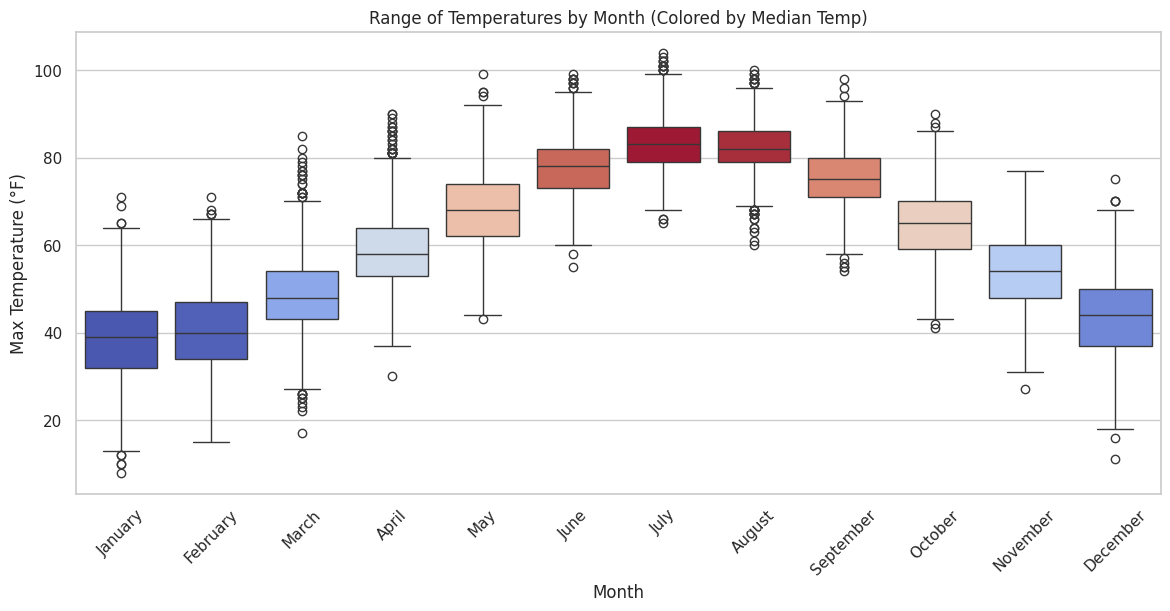

In [5]:
# Extract Month Name for labeling
df['month_name'] = df['DATE'].dt.month_name()

# Define the correct order for the plot (otherwise it sorts them alphabetically)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']


monthly_median = df.groupby('month_name')['TMAX'].median().reindex(month_order)

# Create a color mapper and boxplot
norm = mcolors.Normalize(vmin=monthly_median.min(), vmax=monthly_median.max())
palette_colors = list(cm.coolwarm(norm(monthly_median.values)))

plt.figure(figsize=(14, 6))
sns.boxplot(
    x='month_name', 
    y='TMAX', 
    data=df, 
    order=month_order, 
    palette=palette_colors, 
    hue='month_name', 
    legend=False
)

plt.title('Range of Temperatures by Month (Colored by Median Temp)')
plt.ylabel('Max Temperature (°F)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()

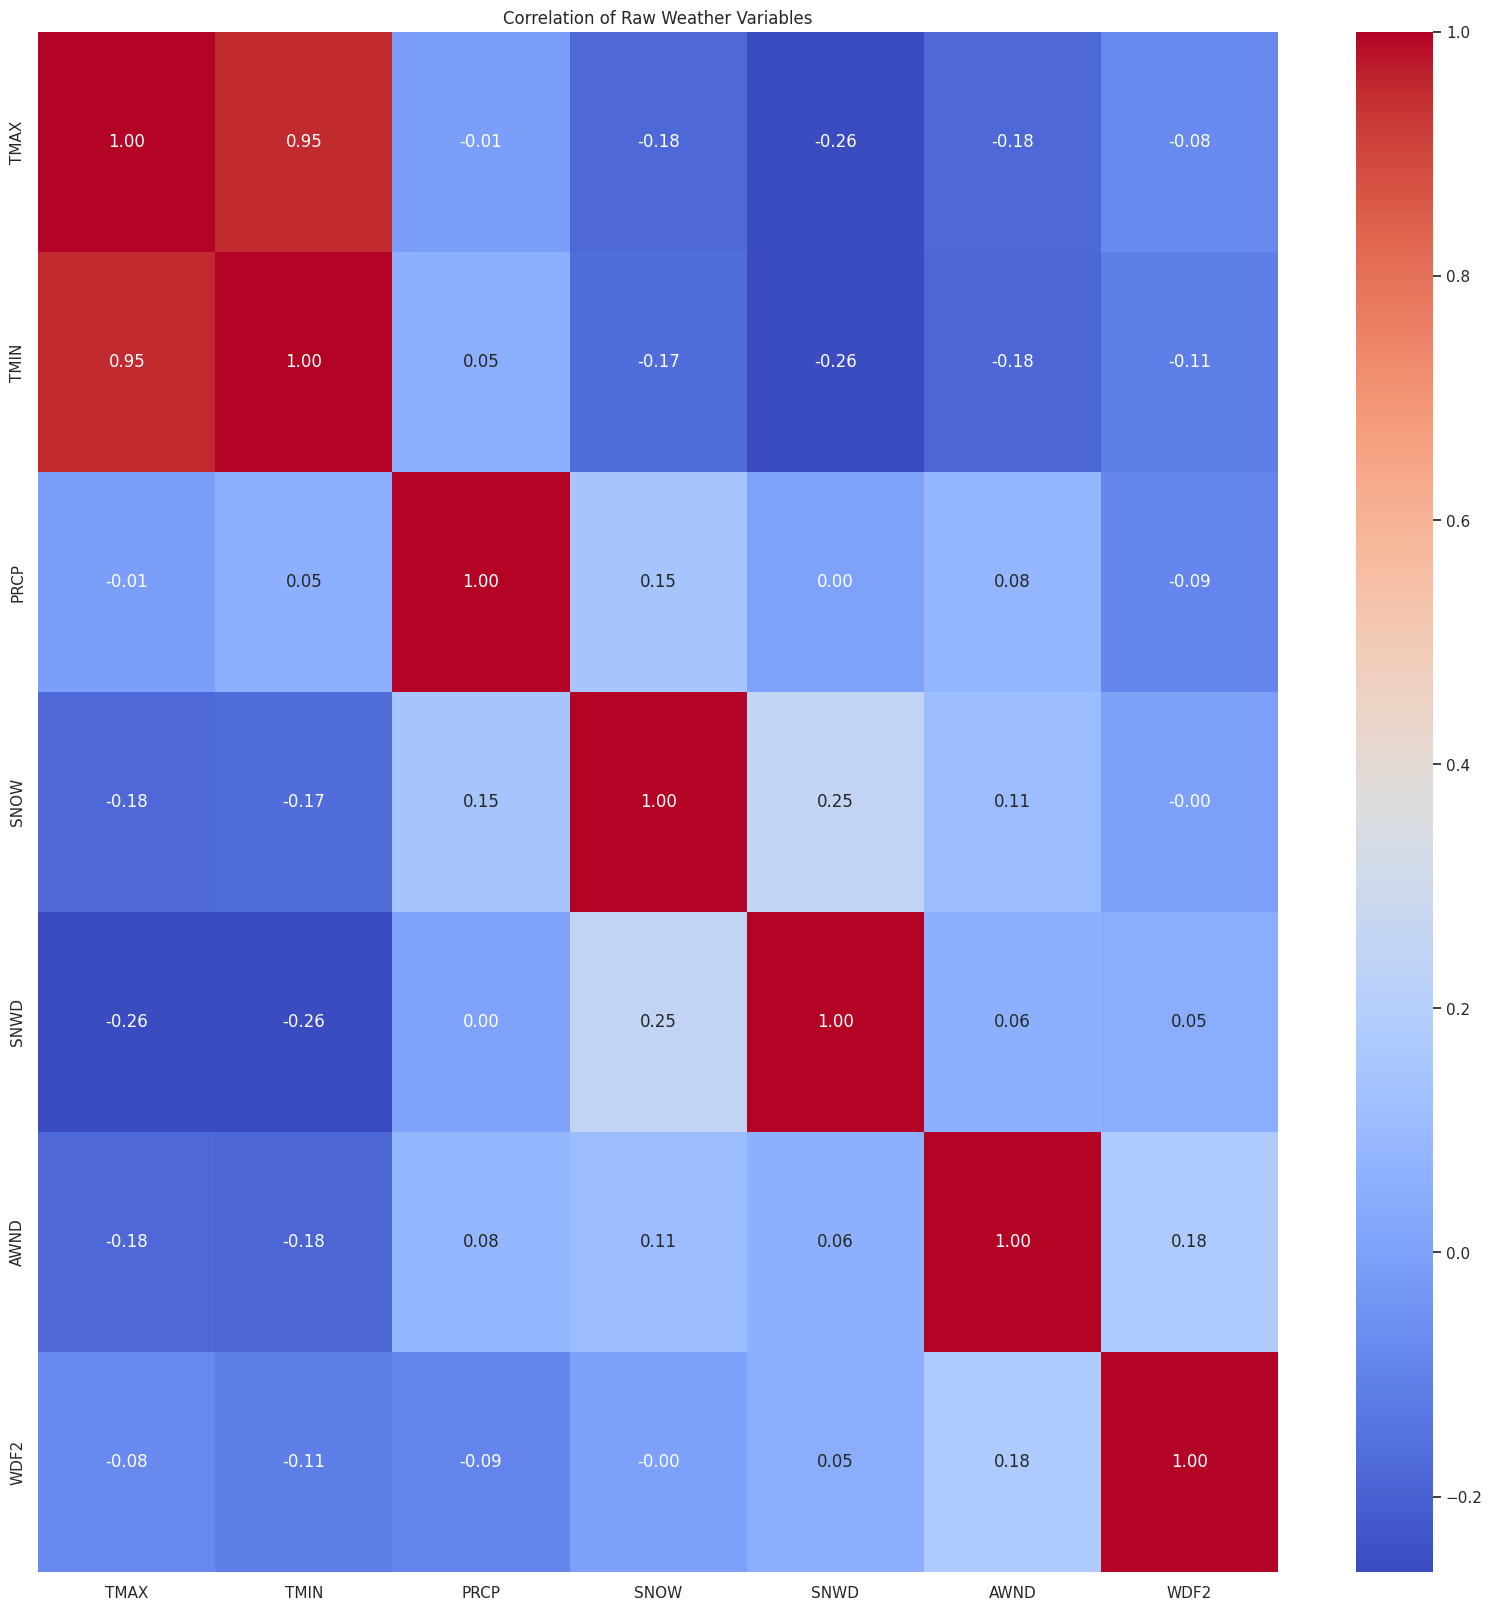

In [7]:
# Calculate correlation
corr_matrix = df[cols_to_numeric].corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Raw Weather Variables')
plt.show()


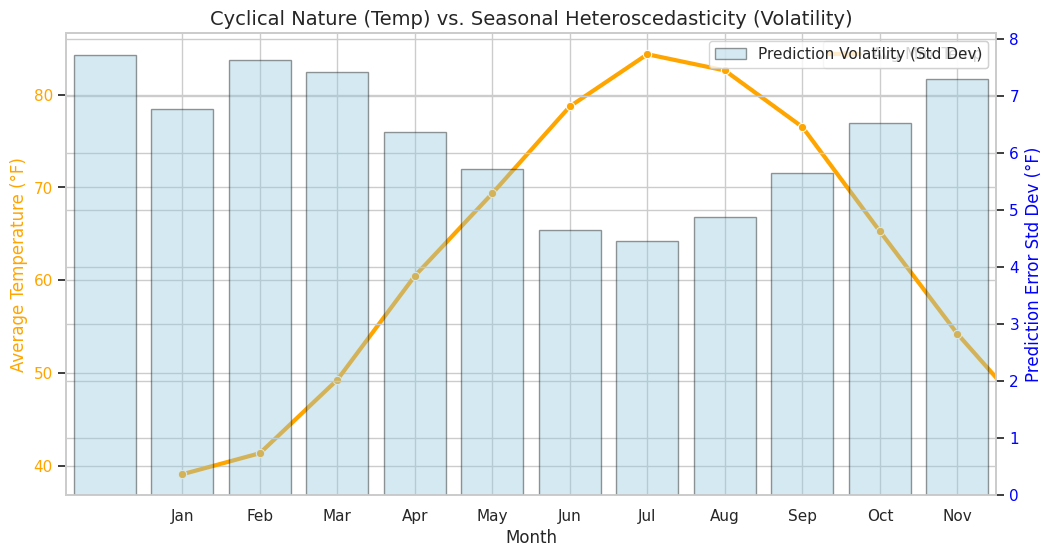

In [52]:
# 1. Sort to ensure time alignment
df = df.sort_values('DATE')

# 2. Create "Lagged" Features (Yesterday's Data)
# We use Yesterday's Low, High, and Precip to predict Today's High
df['TMIN_yesterday'] = df['TMIN'].shift(1)
df['TMAX_yesterday'] = df['TMAX'].shift(1)
df['PRCP_yesterday'] = df['PRCP'].shift(1)
df['SNOW_yesterday'] = df['SNOW'].shift(1)
df['SNWD_yesterday'] = df['SNWD'].shift(1)

# 3. Define Features (Note: We removed the raw 'TMIN' column)
feature_cols = ['TMIN_yesterday', 'TMAX_yesterday', 'PRCP_yesterday', 'SNOW_yesterday', 'SNWD_yesterday']

# 4. Drop the first row (which now has NaNs due to shifting)
df_clean = df.dropna(subset=feature_cols + ['TMAX']).copy()

X = df_clean[feature_cols].copy()
y = df_clean['TMAX'].copy()

# 5. Create Splits (Manual Time Split)
split_index = int(len(df_clean) * 0.8)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]

X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]


# Perform (ridge) regression with cross-validation to find the best alpha
alphas = np.linspace(0.1, 100.0, 100)
ridge_model = RidgeCV(alphas=alphas, scoring='neg_median_absolute_error', cv=10)
ridge_model.fit(X_train, y_train)

p = ridge_model.alpha_
# Make predictions on the test set
y_pred = ridge_model.predict(X_test)
ridge_mae = mean_absolute_error(y_test, y_pred)


# Prepare data for evaluation
results = pd.DataFrame({
    'Date': df.loc[y_test.index, 'DATE'],
    'Actual_TMAX': y_test,
    'Residuals': y_test - ridge_model.predict(X_test) # Or use your specific model predictions
})

results['Month'] = results['Date'].dt.month

# Calculate Metrics per Month
monthly_stats = results.groupby('Month').agg({
    'Actual_TMAX': 'mean',          # The "Cyclical Nature" (Temperature)
    'Residuals': 'std'              # The "Heteroscedasticity" (Uncertainty)
})

# 3. Plot with Dual Axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Temperature (The Cycle)
sns.lineplot(data=monthly_stats, x=monthly_stats.index, y='Actual_TMAX', 
             ax=ax1, color='orange', marker='o', linewidth=3, label='Avg Max Temp')
ax1.set_ylabel('Average Temperature (°F)', color='orange', fontsize=12)
ax1.tick_params(axis='y', labelcolor='orange')
ax1.set_xlabel('Month')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Create a second y-axis for Volatility
ax2 = ax1.twinx()
sns.barplot(data=monthly_stats, x=monthly_stats.index, y='Residuals', 
            ax=ax2, color='skyblue', alpha=0.4, edgecolor='black', label='Prediction Volatility (Std Dev)')
ax2.set_ylabel('Prediction Error Std Dev (°F)', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')

# Title and Legend
plt.title('Cyclical Nature (Temp) vs. Seasonal Heteroscedasticity (Volatility)', fontsize=14)
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()

plt.show()


Over the years weather events may have become more volatile and this would affect the model performance and give unrealistic confidence in our predictions. To test if this is the case let's use the Breusch-Pagan test for heteroskedasticity. 

In [81]:
# Prepare data for Breusch-Pagan test
X_test_with_const = sm.add_constant(X_test)
residuals = y_test - y_pred

# Perform the test for heteroscedasticity
lm, p_lm, fvalue, p_fvalue = het_breuschpagan(residuals, X_test_with_const)

print(f"Lagrange Multiplier statistic: {lm:.4f}")
print(f"P-value: {p_lm:.4e}")

if p_lm < 0.05:
    print("Result: Heteroscedasticity detected! (Variance is changing)")
else:
    print("Result: Homoscedasticity assumed (Variance is constant)")

Lagrange Multiplier statistic: 360.5026
P-value: 9.5860e-76
Result: Heteroscedasticity detected! (Variance is changing)



### 1.2 Modeling Strategy
Based on the volatility findings, a standard regression model would fail to capture the changing risk profile across seasons.

**Decision:** I will utilize **XGBoost Quantile Regression**.
* *Why?* This approach allows us to quantify seasonal uncertainty by predicting confidence intervals (e.g., 5th and 95th percentiles) rather than just a simple mean.

## 2. Feature Engineering: The "Time Machine"
We backfill missing historical wind data using a climatological approach (2000-2024 averages applied to 1960-1999) and generate Lag features to capture atmospheric inertia.

In [71]:
# ==============================================================================
# WIND ENGINEERING & BACKFILLING
# ==============================================================================
print("Backfilling historical wind data...")
# A. Convert Degrees to Vectors
df['Wind_Rad'] = df['WDF2'] * np.pi / 180
df['Wind_Sin'] = np.sin(df['Wind_Rad'])
df['Wind_Cos'] = np.cos(df['Wind_Rad'])

# B. Create Climatology from modern data (2000+)
df['DayOfYear'] = df['DATE'].dt.dayofyear
modern_data = df[df['DATE'].dt.year >= 2000]
wind_climatology = modern_data.groupby('DayOfYear')[['Wind_Sin', 'Wind_Cos', 'AWND']].mean()

# C. Fill missing past using the Climatology
for col in ['Wind_Sin', 'Wind_Cos', 'AWND']:
    fill_values = df['DayOfYear'].map(wind_climatology[col])
    df[col] = df[col].fillna(fill_values)

# ==============================================================================
# FEATURE CREATION
# ==============================================================================
print("Generating features...")
# A. Weather Types (WT)
wt_cols = ['WT01', 'WT03', 'WT08', 'WT18']
df[wt_cols] = df[wt_cols].fillna(0)

df['Fog_Yesterday'] = df['WT01'].shift(1)
df['Thunder_Yesterday'] = df['WT03'].shift(1)
df['Haze_Yesterday'] = df['WT08'].shift(1)
df['Snow_Event_Yesterday'] = df['WT18'].shift(1)

# B. Wind Lags
df['Wind_Sin_Lag1'] = df['Wind_Sin'].shift(1)
df['Wind_Cos_Lag1'] = df['Wind_Cos'].shift(1)
df['AWND_Lag1'] = df['AWND'].shift(1)

# C. Temperature Lags & Trends
df['TMAX_Lag1'] = df['TMAX'].shift(1)
df['TMAX_Lag2'] = df['TMAX'].shift(2)
df['TMIN_Lag1'] = df['TMIN'].shift(1)
df['Rolling_Mean_3'] = df['TMAX'].shift(1).rolling(window=3).mean()
df['Diff_Yesterday'] = df['TMAX'].shift(1) - df['TMIN'].shift(1)

# D. Cyclical Time
df['Sin_Day'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['Cos_Day'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['Month'] = df['DATE'].dt.month

Backfilling historical wind data...
Generating features...


## 3. Training Setup
We use an 80/20 Time Series Split and calculate **Daily** and **Monthly** historical averages using *only* the training set to prevent data leakage.

In [72]:
# ==============================================================================
# 4. SPLIT & HISTORICAL AVERAGES
# ==============================================================================
features = [
    'TMAX_Lag1', 'TMAX_Lag2', 'TMIN_Lag1',
    'Rolling_Mean_3', 'Diff_Yesterday',
    'Wind_Sin_Lag1', 'Wind_Cos_Lag1', 'AWND_Lag1',
    'Fog_Yesterday', 'Thunder_Yesterday', 'Haze_Yesterday', 'Snow_Event_Yesterday',
    'Sin_Day', 'Cos_Day', 
    'Hist_Month_Avg', 'Hist_Day_Avg',
    'PRCP', 'SNOW', 'SNWD'
]

# Filter NaNs
temp_feats = [f for f in features if f not in ['Hist_Month_Avg', 'Hist_Day_Avg']]
df_clean = df.dropna(subset=temp_feats + ['TMAX']).copy()

# Split Indices
split_point = int(len(df_clean) * 0.8)

# Calculate Historical Averages (TRAIN SET ONLY)
train_df = df_clean.iloc[:split_point]

monthly_avgs = train_df.groupby('Month')['TMAX'].mean().to_dict()
df_clean['Hist_Month_Avg'] = df_clean['Month'].map(monthly_avgs)

daily_avgs = train_df.groupby('DayOfYear')['TMAX'].mean().to_dict()
df_clean['Hist_Day_Avg'] = df_clean['DayOfYear'].map(daily_avgs)

# Define X and y
X_max = df_clean[features]
y_max = df_clean['TMAX']

X_train_max, X_test_max = X_max.iloc[:split_point], X_max.iloc[split_point:]
y_train_max, y_test_max = y_max.iloc[:split_point], y_max.iloc[split_point:]
print(f"(TMAX) Training on {len(X_train_max)} rows. Testing on {len(X_test_max)} rows.")

# =======================================================================

df_clean_2 = df.dropna(subset=temp_feats + ['TMIN']).copy()

# Split Indices
split_point = int(len(df_clean_2) * 0.8)

# Calculate Historical Averages (TRAIN SET ONLY)
train_df = df_clean_2.iloc[:split_point]

monthly_avgs = train_df.groupby('Month')['TMIN'].mean().to_dict()
df_clean_2['Hist_Month_Avg'] = df_clean_2['Month'].map(monthly_avgs)

daily_avgs = train_df.groupby('DayOfYear')['TMIN'].mean().to_dict()
df_clean_2['Hist_Day_Avg'] = df_clean_2['DayOfYear'].map(daily_avgs)
# Define X and y
X_min = df_clean_2[features]
y_min = df_clean_2['TMIN']

X_train_min, X_test_min = X_min.iloc[:split_point], X_min.iloc[split_point:]
y_train_min, y_test_min = y_min.iloc[:split_point], y_min.iloc[split_point:]

print(f"(TMIN) Training on {len(X_train_min)} rows. Testing on {len(X_test_min)} rows.")

(TMAX) Training on 16068 rows. Testing on 4018 rows.
(TMIN) Training on 16068 rows. Testing on 4018 rows.


In [59]:
# ==============================================================================
# 5. OPTUNA TUNING
# ==============================================================================
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'objective': 'reg:absoluteerror',
        'n_jobs': -1,
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_train_max, y_train_max) 
    preds = model.predict(X_test_max)
    return mean_absolute_error(y_test_max, preds)

print("Tuning hyperparameters...")
study_max = optuna.create_study(direction='minimize')
study_max.optimize(objective, n_trials=100) 

print(f"Best MAE: {study_max.best_value:.4f}")
final_mae_max= study_max.best_value

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'objective': 'reg:absoluteerror',
        'n_jobs': -1,
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_train_min, y_train_min) 
    preds = model.predict(X_test_min)
    return mean_absolute_error(y_test_min, preds)

print("Tuning hyperparameters...")
study_min = optuna.create_study(direction='minimize')
study_min.optimize(objective, n_trials=100) 

print(f"Best MAE: {study_min.best_value:.4f}")
final_mae_min= study_min.best_value

[I 2026-01-19 10:22:06,163] A new study created in memory with name: no-name-dd666887-91c7-4c1a-aeac-e0fda20fcefa


Tuning hyperparameters...


[I 2026-01-19 10:22:12,327] Trial 0 finished with value: 4.169604720613623 and parameters: {'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.028015449965102007, 'subsample': 0.6290573277313584, 'colsample_bytree': 0.7521476399799113, 'reg_alpha': 8.276129472937521, 'reg_lambda': 1.6709551847728932}. Best is trial 0 with value: 4.169604720613623.
[I 2026-01-19 10:22:15,035] Trial 1 finished with value: 4.147739315934891 and parameters: {'n_estimators': 724, 'max_depth': 7, 'learning_rate': 0.03726185035666968, 'subsample': 0.9161681108285662, 'colsample_bytree': 0.7483566055027098, 'reg_alpha': 6.805761349757795, 'reg_lambda': 8.264483508329857}. Best is trial 1 with value: 4.147739315934891.
[I 2026-01-19 10:22:17,103] Trial 2 finished with value: 4.119739415694256 and parameters: {'n_estimators': 922, 'max_depth': 4, 'learning_rate': 0.025979555194165952, 'subsample': 0.6660335692123548, 'colsample_bytree': 0.6654771005476239, 'reg_alpha': 1.7687288941167378, 'reg_lambda': 4.56

Best MAE: 4.1069
Tuning hyperparameters...


[I 2026-01-19 10:25:30,164] Trial 0 finished with value: 2.998015173042871 and parameters: {'n_estimators': 763, 'max_depth': 5, 'learning_rate': 0.036737107968413715, 'subsample': 0.9603089211083053, 'colsample_bytree': 0.7713469685658506, 'reg_alpha': 1.7354984604528911, 'reg_lambda': 8.191757958551612}. Best is trial 0 with value: 2.998015173042871.
[I 2026-01-19 10:25:30,943] Trial 1 finished with value: 2.992845047404364 and parameters: {'n_estimators': 420, 'max_depth': 3, 'learning_rate': 0.1300795488415288, 'subsample': 0.6544868877868326, 'colsample_bytree': 0.6555649762874001, 'reg_alpha': 3.7569309541744635, 'reg_lambda': 2.497179551476516}. Best is trial 1 with value: 2.992845047404364.
[I 2026-01-19 10:25:33,222] Trial 2 finished with value: 3.03770616672833 and parameters: {'n_estimators': 929, 'max_depth': 5, 'learning_rate': 0.10909480219522852, 'subsample': 0.8607417063499271, 'colsample_bytree': 0.9117387050184673, 'reg_alpha': 1.8216579287817902, 'reg_lambda': 4.7181

Best MAE: 2.9687


## 4. Modeling: The Quantile "Safety Tunnel"
We train three models using the hyperparameters identified in our previous Optuna study.

Training Final Volatility-Aware Tunnel...
{'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.03184079463622287, 'subsample': 0.7093676333469952, 'colsample_bytree': 0.615069702494021, 'reg_alpha': 8.497485797807963, 'reg_lambda': 8.969796234392428}


<Figure size 1000x500 with 0 Axes>

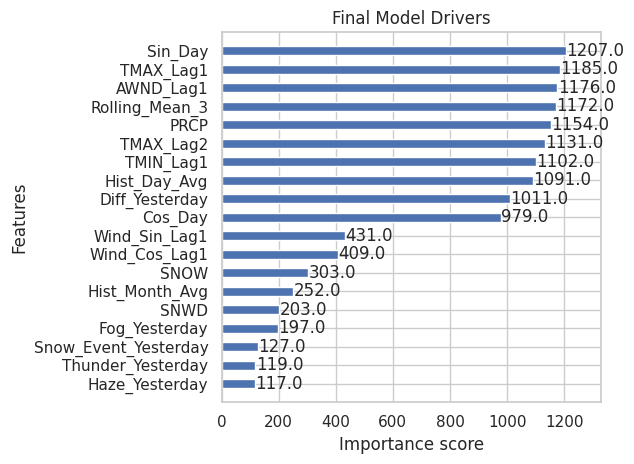

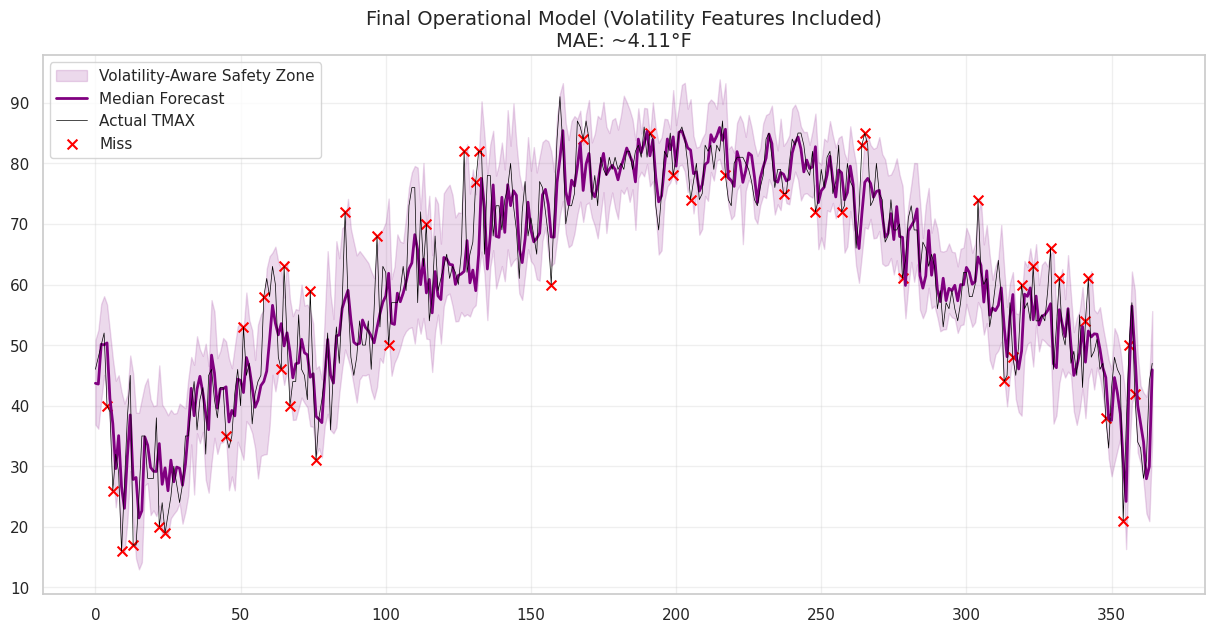

In [ ]:
print("Training Final Volatility-Aware Tunnel...")
q_params = study_max.best_params.copy()
print(q_params)

q_params_max = {
    'n_estimators': 868, 
    'max_depth': 4, 
    'learning_rate': 0.05682801933374486, 
    'subsample': 0.9135732156624227, 
    'colsample_bytree': 0.7387596608538658, 
    'reg_alpha': 8.046920463646087, 
    'reg_lambda': 3.7043435368691187,
    'n_jobs': -1,
    'random_state': 42
}

q_params_max['objective'] = 'reg:quantileerror'

m_low_max  = xgb.XGBRegressor(**q_params_max, quantile_alpha=0.05).fit(X_train_max, y_train_max)
m_mid_max  = xgb.XGBRegressor(**q_params_max, quantile_alpha=0.50).fit(X_train_max, y_train_max)
m_high_max = xgb.XGBRegressor(**q_params_max, quantile_alpha=0.95).fit(X_train_max, y_train_max)

# 2. Predict
p_low_max  = m_low_max.predict(X_test_max)
p_mid_max  = m_mid_max.predict(X_test_max)
p_high_max = m_high_max.predict(X_test_max)

# 3. Plot Feature Importance (Did it use the new features?)
plt.figure(figsize=(10, 5))
xgb.plot_importance(m_mid_max, height=0.5, 
                   title="Final Model Drivers", 
                   importance_type='weight')
plt.tight_layout()
plt.show()

# 4. Plot The Final Tunnel
plt.figure(figsize=(15, 7))
subset = 365
dates_plot = range(subset)

# Plot the Tunnel
plt.fill_between(dates_plot, p_low_max[:subset], p_high_max[:subset], color='purple', alpha=0.15, label='Volatility-Aware Safety Zone')
plt.plot(dates_plot, p_mid_max[:subset], color='purple', linewidth=2, label='Median Forecast')
plt.plot(dates_plot, y_test.iloc[:subset], color='black', label='Actual TMAX', linewidth=0.5)

# Highlight Misses
actuals = y_test.iloc[:subset].values
mask = (actuals < p_low_max[:subset]) | (actuals > p_high_max[:subset])
plt.scatter(np.array(dates_plot)[mask], actuals[mask], color='red', marker='x', s=50, label='Miss')

plt.title(f'Final Operational Model (Volatility Features Included)\nMAE: ~{final_mae_max:.2f}°F', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
print("Training Final Volatility-Aware Tunnel...")
q_params = study_min.best_params.copy()
print(q_params)
q_params['objective'] = 'reg:quantileerror'

m_low_min  = xgb.XGBRegressor(**q_params, quantile_alpha=0.05).fit(X_train_min, y_train_min)
m_mid_min  = xgb.XGBRegressor(**q_params, quantile_alpha=0.50).fit(X_train_min, y_train_min)
m_high_min = xgb.XGBRegressor(**q_params, quantile_alpha=0.95).fit(X_train_min, y_train_min)

# 2. Predict
p_low_min  = m_low_min.predict(X_test_min)
p_mid_min  = m_mid_min.predict(X_test_min)
p_high_min = m_high_min.predict(X_test_min)

# 3. Plot Feature Importance (Did it use the new features?)
plt.figure(figsize=(10, 5))
xgb.plot_importance(m_mid_min,  height=0.5, 
                   title="Final Model Drivers", 
                   importance_type='weight')
plt.tight_layout()
plt.show()

# 4. Plot The Final Tunnel
plt.figure(figsize=(15, 7))
subset = 365
dates_plot = range(subset)

# Plot the Tunnel
plt.fill_between(dates_plot, p_low_min[:subset], p_high_min[:subset], color='purple', alpha=0.15, label='Volatility-Aware Safety Zone')
plt.plot(dates_plot, p_mid_min[:subset], color='purple', linewidth=2, label='Median Forecast')
plt.plot(dates_plot, y_test_min.iloc[:subset], color='black', label='Actual TMAX', linewidth=0.5)

# Highlight Misses
actuals = y_test_min.iloc[:subset].values
mask = (actuals < p_low_min[:subset]) | (actuals > p_high_min[:subset])
plt.scatter(np.array(dates_plot)[mask], actuals[mask], color='red', marker='x', s=50, label='Miss')

plt.title(f'Final Operational Model (Volatility Features Included)\nMAE: ~{final_mae_min:.2f}°F', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

Training Final Volatility-Aware Tunnel...
{'n_estimators': 838, 'max_depth': 5, 'learning_rate': 0.02782095539000955, 'subsample': 0.6006492450379086, 'colsample_bytree': 0.8567563295032506, 'reg_alpha': 6.196478079243171, 'reg_lambda': 3.249283925555016}


/home/aronf/Desktop/Eurail/application/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [12:10:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "quantile_alpha" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/aronf/Desktop/Eurail/application/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [12:10:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "quantile_alpha" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/aronf/Desktop/Eurail/application/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [12:10:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "quantile_alpha" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


KeyboardInterrupt: 

## 5. Evaluation & Forensics

In [88]:
# ==============================================================================
# 6. EVALUATION REPORT
# ==============================================================================
# 1. Metrics

def metrics(y_test, p_low, p_mid, p_high, m_low, m_mid, m_high):
    mae = mean_absolute_error(y_test, p_mid)
    inside_tunnel = (y_test >= p_low) & (y_test <= p_high)
    coverage_score = inside_tunnel.mean() * 100
    avg_width = np.mean(p_high - p_low)

    print(f"\nMEDIAN MAE: {mae:.4f} °F")
    print(f"TUNNEL COVERAGE: {coverage_score:.2f}% (Target: 90%)")
    print(f"AVG TUNNEL WIDTH: {avg_width:.2f} °F")

    # 2. Visualization (The Tunnel)
    plt.figure(figsize=(15, 7))
    subset = 365
    dates_plot = range(subset)

    plt.fill_between(dates_plot, p_low[:subset], p_high[:subset], color='purple', alpha=0.15, label='Safety Zone (5-95%)')
    plt.plot(dates_plot, p_mid[:subset], color='purple', linewidth=2, label='Median Forecast')
    plt.plot(dates_plot, y_test.iloc[:subset].values, color='black', label='Actual TMAX', linewidth=0.5)

    # Misses
    act_sub = y_test.iloc[:subset].values
    mask = (act_sub < p_low[:subset]) | (act_sub > p_high[:subset])
    plt.scatter(np.array(dates_plot)[mask], act_sub[mask], color='red', marker='x', s=50, label='Miss')

    plt.title(f'Final Operational Model\nMedian MAE: {mae:.2f}°F', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()

    # 3. Feature Importance Split (3-Way)
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    xgb.plot_importance(m_low, ax=axes[0], max_num_features=12, height=0.5, title="Drivers of COLD (5th %)", color='#1f77b4')
    xgb.plot_importance(m_mid, ax=axes[1], max_num_features=12, height=0.5, title="Drivers of MEDIAN (50th %)", color='#2ca02c')
    xgb.plot_importance(m_high, ax=axes[2], max_num_features=12, height=0.5, title="Drivers of HEAT (95th %)", color='#d62728')
    plt.tight_layout()
    plt.show()


MEDIAN MAE: 4.1243 °F
TUNNEL COVERAGE: 86.39% (Target: 90%)
AVG TUNNEL WIDTH: 16.44 °F


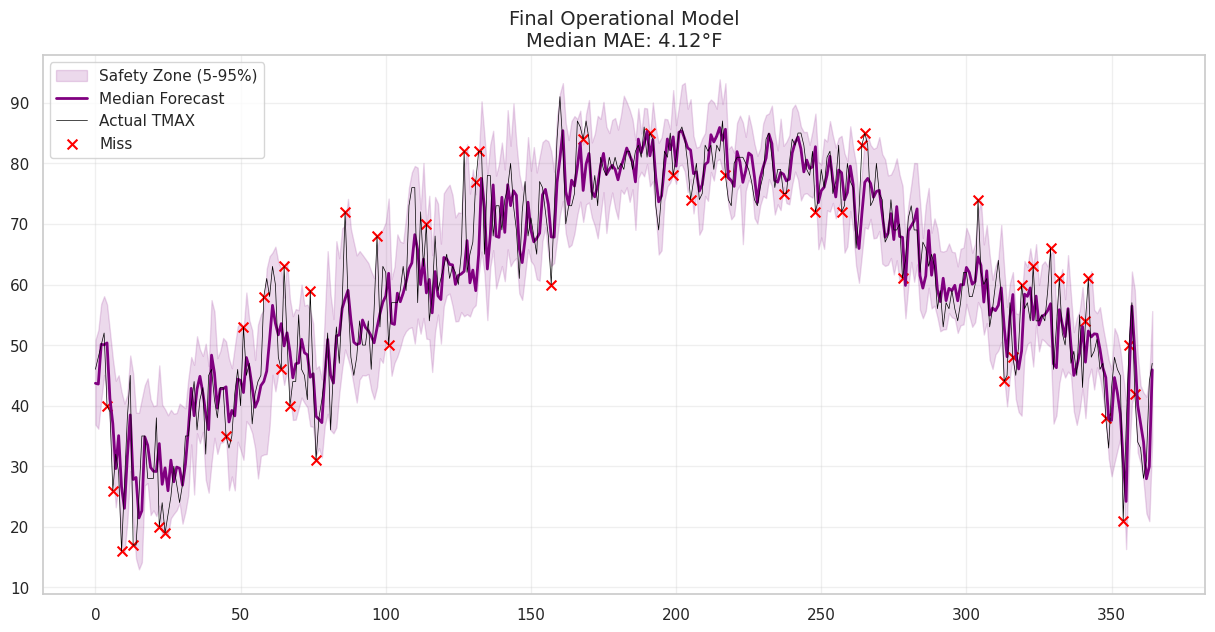

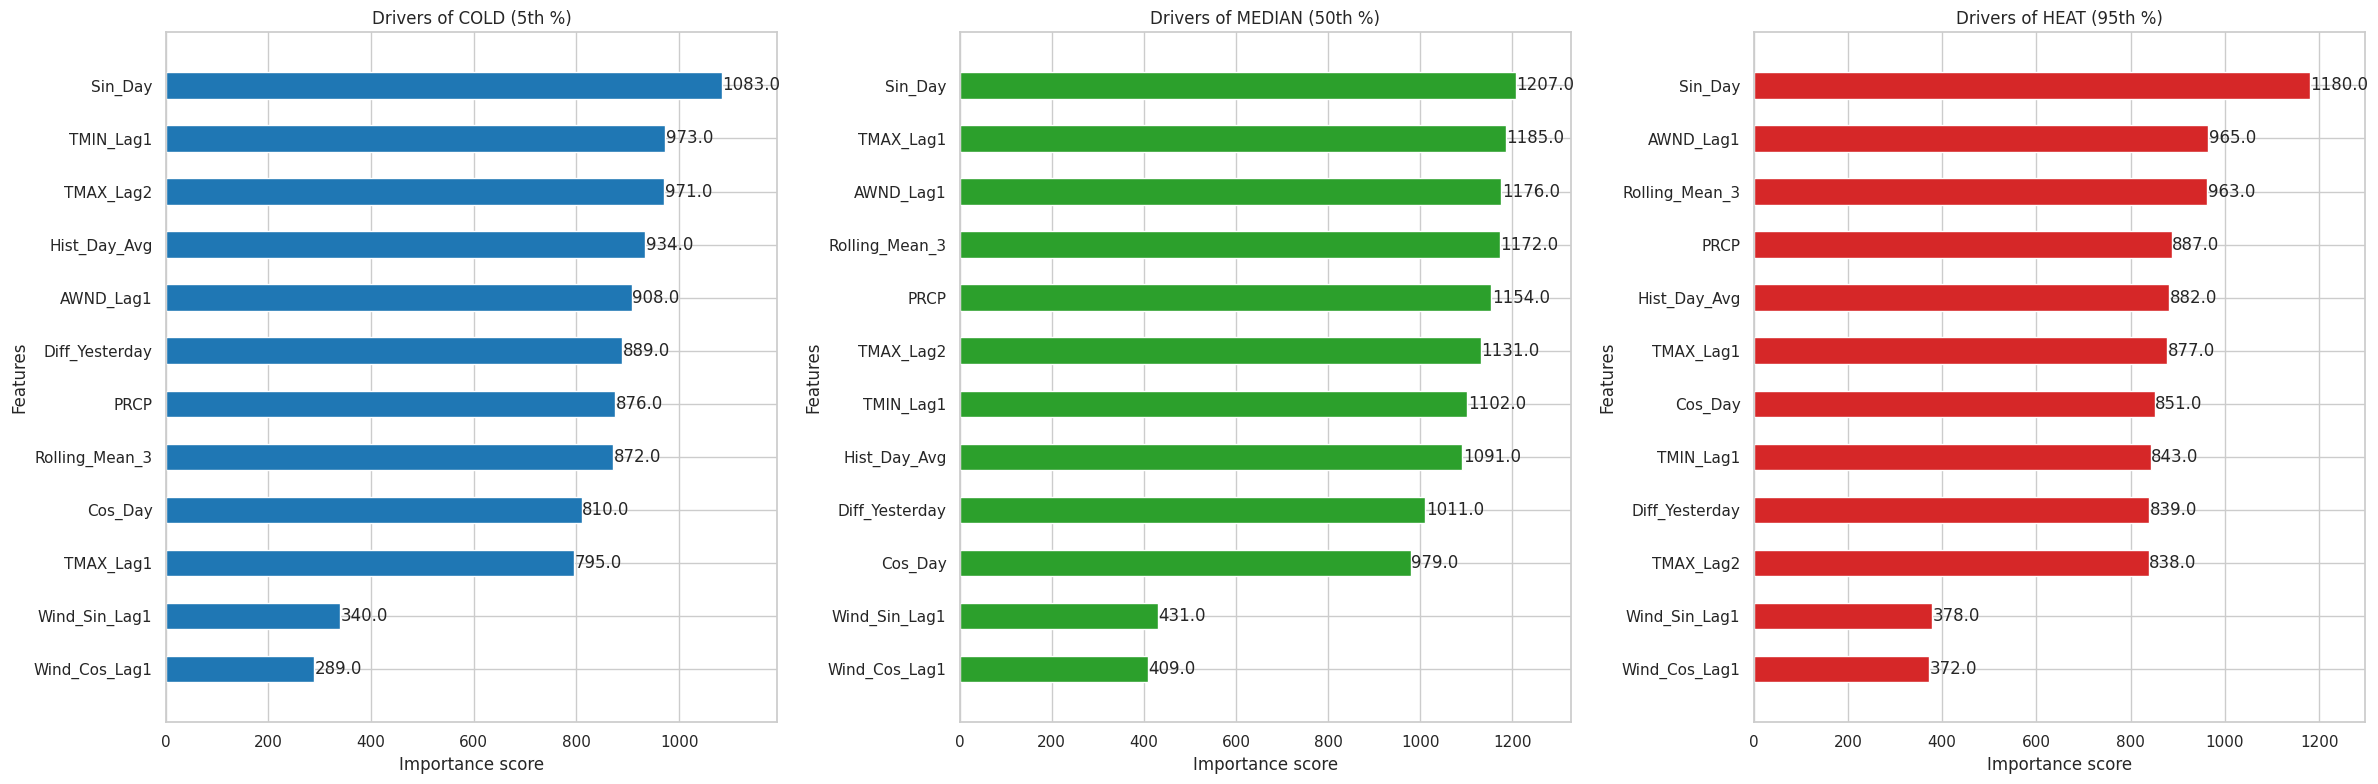


MEDIAN MAE: 2.9928 °F
TUNNEL COVERAGE: 85.64% (Target: 90%)
AVG TUNNEL WIDTH: 11.78 °F


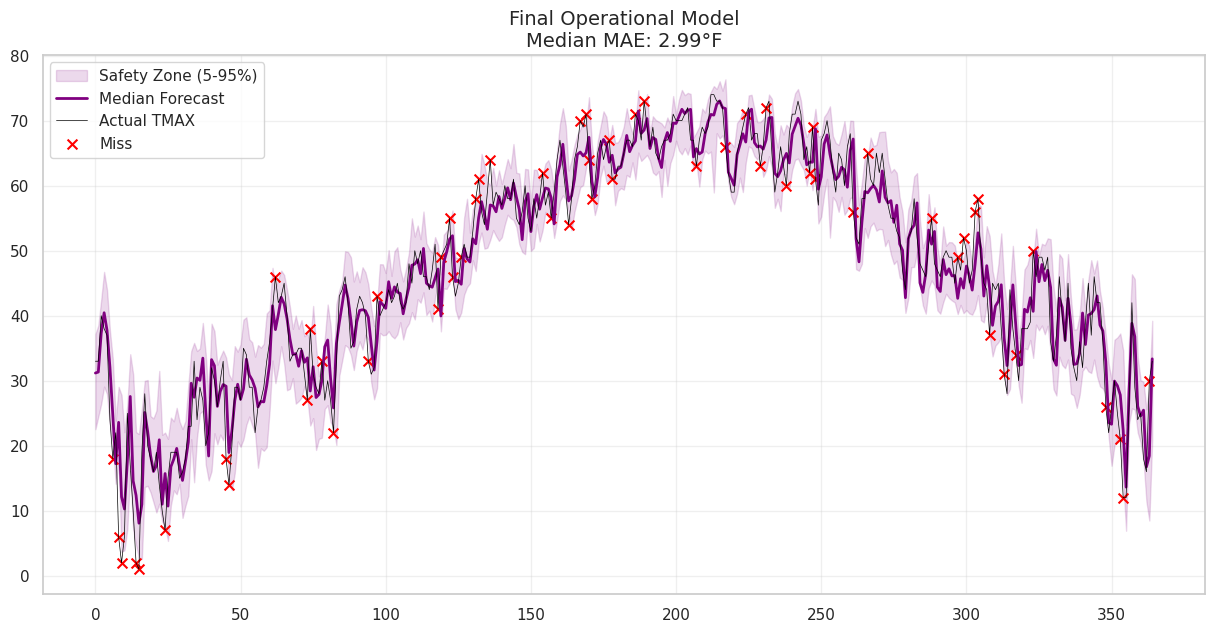

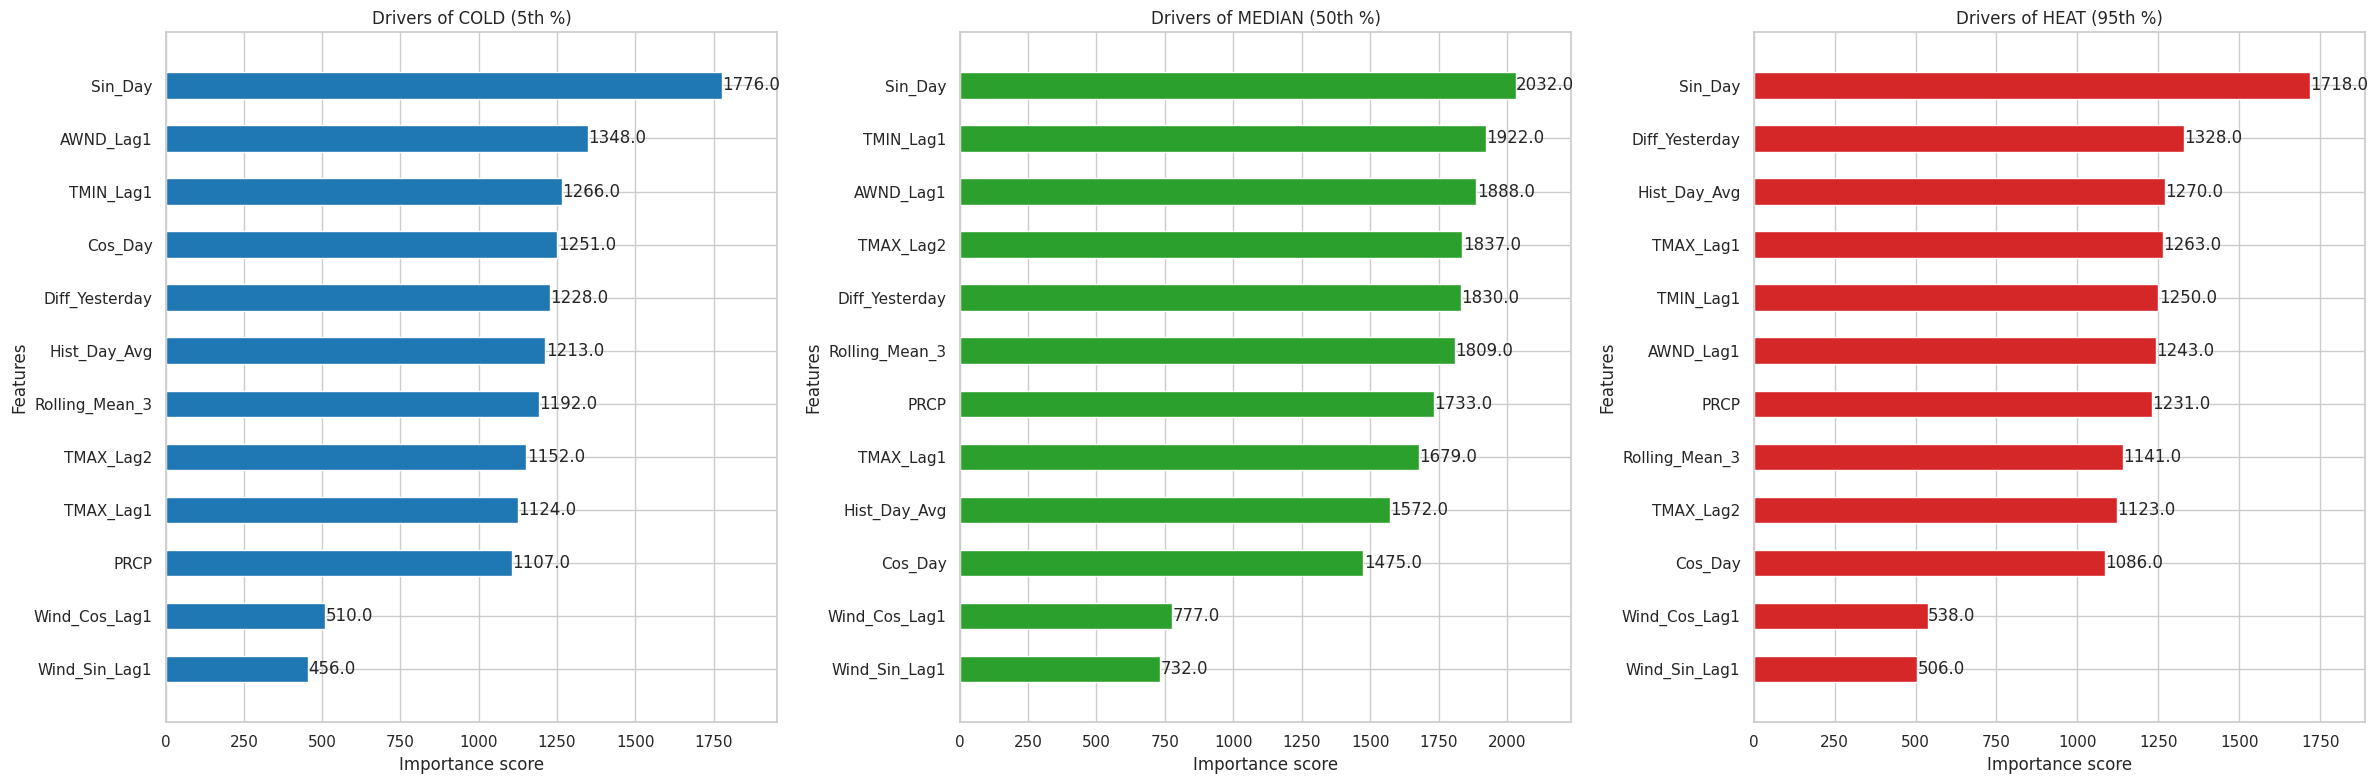

In [89]:
metrics(y_test_max, p_low_max, p_mid_max, p_high_max, m_low_max, m_mid_max, m_high_max)
metrics(y_test_min, p_low_min, p_mid_min, p_high_min, m_low_min, m_mid_min, m_high_min)

In [90]:
# ==============================================================================
# 8. POST-TRAINING EVALUATION & FORENSIC ANALYSIS
# ==============================================================================
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
def post_training_metrics(y_test, p_low, p_mid, p_high):
    # ---------------------------------------------------------
    # A. QUANTITATIVE METRICS
    # ---------------------------------------------------------
    # 1. Standard Regression Metrics (based on Median Forecast)
    mae = mean_absolute_error(y_test, p_mid)
    rmse = np.sqrt(mean_squared_error(y_test, p_mid))
    r2 = r2_score(y_test, p_mid)

    # 2. Safety Tunnel Metrics (Quantile Performance)
    # Coverage: What % of actual temps fell INSIDE our 5%-95% tunnel?
    inside_tunnel = (y_test >= p_low) & (y_test <= p_high)
    coverage_score = inside_tunnel.mean() * 100

    # Width: How wide is the tunnel on average? (Narrower = More Certain)
    avg_tunnel_width = np.mean(p_high - p_low)

    print("\n" + "="*50)
    print("FINAL MODEL REPORT CARD")
    print("="*50)
    print(f"✅ Median MAE:       {mae:.4f} °F  (Typical Error)")
    print(f"✅ Root Mean Sq:     {rmse:.4f} °F  (Penalizes large errors)")
    print(f"✅ R² Score:         {r2:.4f}      (Variance explained)")
    print("-" * 50)
    print(f"🛡️ Tunnel Coverage:  {coverage_score:.2f}%     (Target: 90.00%)")
    print(f"📏 Avg Tunnel Width: {avg_tunnel_width:.2f} °F (Avg Uncertainty)")
    print("="*50 + "\n")

    # ---------------------------------------------------------
    # B. VISUALIZATION DASHBOARD
    # ---------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # 1. The Tunnel (Time Series)
    subset = 365
    dates_plot = range(subset)
    ax_tunnel = axes[0, 0]
    ax_tunnel.fill_between(dates_plot, p_low[:subset], p_high[:subset], color='purple', alpha=0.15, label='Safety Zone (5-95%)')
    ax_tunnel.plot(dates_plot, p_mid[:subset], color='purple', linewidth=2, label='Median Forecast')
    ax_tunnel.plot(dates_plot, y_test.iloc[:subset].values, color='black', label='Actual', linewidth=0.5)
    # Highlight Misses
    actuals_sub = y_test.iloc[:subset].values
    miss_mask = (actuals_sub < p_low[:subset]) | (actuals_sub > p_high[:subset])
    ax_tunnel.scatter(np.array(dates_plot)[miss_mask], actuals_sub[miss_mask], color='red', marker='x', s=50, label='Miss')
    ax_tunnel.set_title("Operational Forecast (First Year of Test Set)")
    ax_tunnel.legend(loc='upper left')

    # 2. Error Distribution (Bias Check)
    errors = y_test - p_mid
    sns.histplot(errors, bins=30, kde=True, color='orange', ax=axes[0, 1])
    axes[0, 1].axvline(x=0, color='black', linestyle='--')
    axes[0, 1].set_title("Error Distribution (Centered on 0?)")
    axes[0, 1].set_xlabel("Error (°F)")

    # 3. Actual vs Predicted (Linearity)
    axes[1, 0].scatter(y_test, p_mid, alpha=0.3, s=10, color='teal')
    axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes[1, 0].set_title("Actual vs. Predicted (Ideal = Diagonal)")
    axes[1, 0].set_xlabel("Actual TMAX")
    axes[1, 0].set_ylabel("Predicted TMAX (Median)")

    # 4. Tunnel Width vs Season (Volatility Check)
    # We need DayOfYear for the test set to see if the tunnel widens in winter
    test_doy = df.loc[y_test.index, 'DayOfYear']
    axes[1, 1].scatter(test_doy, p_high - p_low, alpha=0.2, s=10, color='purple')
    axes[1, 1].set_title("Uncertainty by Season (Tunnel Width)")
    axes[1, 1].set_xlabel("Day of Year (1=Jan, 180=July)")
    axes[1, 1].set_ylabel("Tunnel Width (°F)")

    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # C. FORENSIC ANALYSIS (The "Nightmares")
    # ---------------------------------------------------------
    # Create DataFrame of failures
    analysis_df = X_test.copy()
    analysis_df['Date'] = df.loc[analysis_df.index, 'DATE']
    analysis_df['Actual_TMAX'] = y_test
    analysis_df['Predicted_TMAX'] = p_mid
    analysis_df['Low_Bound'] = p_low
    analysis_df['High_Bound'] = p_high
    analysis_df['Error'] = analysis_df['Actual_TMAX'] - analysis_df['Predicted_TMAX']
    analysis_df['Abs_Error'] = analysis_df['Error'].abs()
    analysis_df['Outside_Tunnel'] = ~((analysis_df['Actual_TMAX'] >= analysis_df['Low_Bound']) & 
                                    (analysis_df['Actual_TMAX'] <= analysis_df['High_Bound']))

    print("\n" + "-"*60)
    print("TOP 10 WORST PREDICTIONS (The Model's Nightmares)")
    print("-" * 60)
    cols = ['Date', 'Actual_TMAX', 'Predicted_TMAX', 'Error', 'Outside_Tunnel', 'TMAX_Lag1']
    print(analysis_df.sort_values('Abs_Error', ascending=False).head(10)[cols].to_string(index=False))


FINAL MODEL REPORT CARD
✅ Median MAE:       4.1243 °F  (Typical Error)
✅ Root Mean Sq:     5.3499 °F  (Penalizes large errors)
✅ R² Score:         0.9062      (Variance explained)
--------------------------------------------------
🛡️ Tunnel Coverage:  86.39%     (Target: 90.00%)
📏 Avg Tunnel Width: 16.44 °F (Avg Uncertainty)



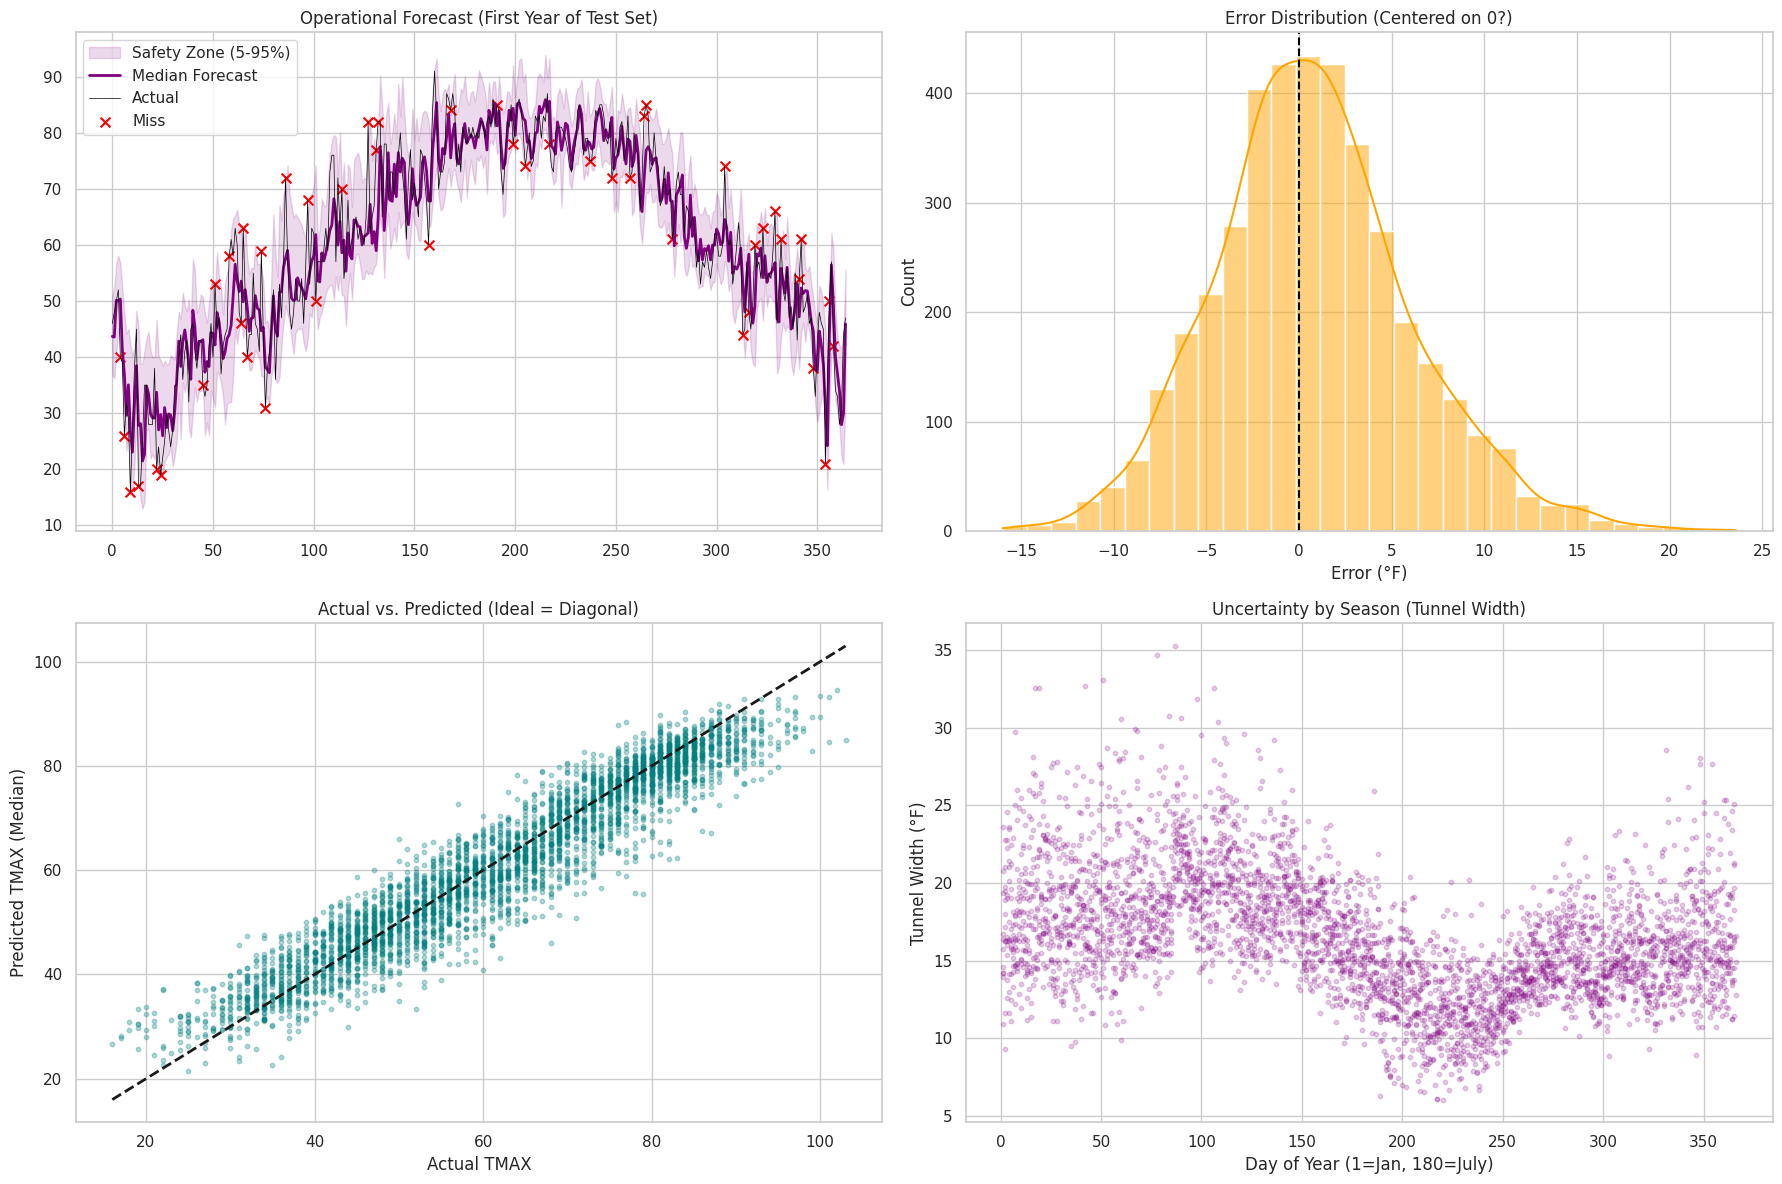


------------------------------------------------------------
TOP 10 WORST PREDICTIONS (The Model's Nightmares)
------------------------------------------------------------


KeyError: "['TMAX_Lag1'] not in index"

In [91]:
post_training_metrics(y_test_max, p_low_max, p_mid_max, p_high_max)
post_training_metrics(y_test_min, p_low_min, p_mid_min, p_high_min)

In [92]:
import pandas as pd
import numpy as np
from datetime import timedelta

def predict_weather_flexible(user_input, models, historical_df):
    """
    Predicts tomorrow's weather using whatever data is available today.
    
    Logic:
    1. Determine the 'Day of Year' from the input date.
    2. Look up historical averages for that specific day to create a 'Baseline'.
    3. Overwrite the Baseline with any specific values provided by the user.
    4. Generate the full feature set required by the XGBoost models.
    """
    # -------------------------------------------------------------------------
    # 1. PARSE DATE & PREPARE HISTORY
    # -------------------------------------------------------------------------
    if 'DATE' not in user_input:
        raise ValueError("Input dictionary must at least contain a 'DATE' key.")
        
    current_date = pd.to_datetime(user_input['DATE'])
    doy = current_date.dayofyear
    
    # Ensure history has DayOfYear for fast lookup
    if 'DayOfYear' not in historical_df.columns:
        historical_df['DayOfYear'] = pd.to_datetime(historical_df['DATE']).dt.dayofyear

    # -------------------------------------------------------------------------
    # 2. GENERATE BASELINE (CLIMATOLOGY)
    # -------------------------------------------------------------------------
    # We get the average conditions for THIS day in history
    day_stats = historical_df[historical_df['DayOfYear'] == doy]
    
    # Define smart defaults if user leaves fields blank
    defaults = {
        'TMAX': day_stats['TMAX'].mean(),
        'TMIN': day_stats['TMIN'].mean(),
        'AWND': day_stats['AWND'].mean(),
        'WDF2': day_stats['WDF2'].median(), # Direction is better as median
        'PRCP': 0.0, # Assume dry unless specified
        'SNOW': 0.0,
        'SNWD': 0.0,
        'WT01': 0, 'WT03': 0, 'WT08': 0, 'WT18': 0 # Assume no severe weather
    }
    
    # Handle edge cases (e.g. Feb 29 or missing data)
    for k, v in defaults.items():
        if pd.isna(v): defaults[k] = 0.0

    # -------------------------------------------------------------------------
    # 3. MERGE USER INPUT
    # -------------------------------------------------------------------------
    # User data takes priority over historical defaults
    current_conditions = defaults.copy()
    current_conditions.update(user_input)
    
    # -------------------------------------------------------------------------
    # 4. FEATURE ENGINEERING
    # -------------------------------------------------------------------------
    # A. Wind Vectors
    wind_rad = current_conditions['WDF2'] * np.pi / 180
    
    # B. Construct Feature Dictionary
    # Note: The model predicts 'Tomorrow', so 'Today's' values become 'Lag1'
    features = {
        # Temperature Lags
        'TMAX_Lag1': current_conditions['TMAX'],
        'TMAX_Lag2': current_conditions['TMAX'], # Approximation
        'TMIN_Lag1': current_conditions['TMIN'],
        'Rolling_Mean_3': current_conditions['TMAX'], # Approximation
        'Diff_Yesterday': current_conditions['TMAX'] - current_conditions['TMIN'],
        
        # Wind Lags
        'Wind_Sin_Lag1': np.sin(wind_rad),
        'Wind_Cos_Lag1': np.cos(wind_rad),
        'AWND_Lag1': current_conditions['AWND'],
        
        # Weather Events (Booleans)
        'Fog_Yesterday': int(current_conditions['WT01'] > 0),
        'Thunder_Yesterday': int(current_conditions['WT03'] > 0),
        'Haze_Yesterday': int(current_conditions['WT08'] > 0),
        'Snow_Event_Yesterday': int(current_conditions['WT18'] > 0),
        
        # Cyclical Time
        'Sin_Day': np.sin(2 * np.pi * doy / 365.0),
        'Cos_Day': np.cos(2 * np.pi * doy / 365.0),
        
        # Tomorrow's Conditions (Unknowns set to 0/False unless user forecasted them)
        'PRCP': current_conditions.get('PRCP', 0),
        'SNOW': current_conditions.get('SNOW', 0),
        'SNWD': current_conditions.get('SNWD', 0),
        
        # Placeholders for Historical Averages (Model specific)
        'Hist_Month_Avg': 0.0,
        'Hist_Day_Avg': 0.0
    }

    # -------------------------------------------------------------------------
    # 5. PREDICTION
    # -------------------------------------------------------------------------
    # Prepare DataFrame
    input_df = pd.DataFrame([features])
    
    # Strict Column Ordering
    feature_order = [
        'TMAX_Lag1', 'TMAX_Lag2', 'TMIN_Lag1',
        'Rolling_Mean_3', 'Diff_Yesterday',
        'Wind_Sin_Lag1', 'Wind_Cos_Lag1', 'AWND_Lag1',
        'Fog_Yesterday', 'Thunder_Yesterday', 'Haze_Yesterday', 'Snow_Event_Yesterday',
        'Sin_Day', 'Cos_Day', 
        'Hist_Month_Avg', 'Hist_Day_Avg',
        'PRCP', 'SNOW', 'SNWD'
    ]
    
    # Calculate stats for the TARGET month/day (Tomorrow)
    target_date = current_date + timedelta(days=1)
    target_month = target_date.month
    target_doy = target_date.dayofyear
    
    hist_month = historical_df[historical_df['DATE'].dt.month == target_month]
    hist_day = historical_df[historical_df['DayOfYear'] == target_doy]
    
    # --- PREDICT TMAX ---
    input_df['Hist_Month_Avg'] = hist_month['TMAX'].mean()
    input_df['Hist_Day_Avg'] = hist_day['TMAX'].mean()
    
    tmax_preds = (
        models['tmax_low'].predict(input_df[feature_order])[0],
        models['tmax_mid'].predict(input_df[feature_order])[0],
        models['tmax_high'].predict(input_df[feature_order])[0]
    )

    # --- PREDICT TMIN ---
    input_df['Hist_Month_Avg'] = hist_month['TMIN'].mean()
    input_df['Hist_Day_Avg'] = hist_day['TMIN'].mean()
    
    tmin_preds = (
        models['tmin_low'].predict(input_df[feature_order])[0],
        models['tmin_mid'].predict(input_df[feature_order])[0],
        models['tmin_high'].predict(input_df[feature_order])[0]
    )
    
    return tmax_preds, tmin_preds

In [93]:
# 1. Load your full history once (e.g. at app startup)
df_history = pd.read_csv("JFK Airport Weather Data.csv", parse_dates=['DATE'])
# (Optional) Clean/Filter history if necessary
# df_history = df_history[df_history['NAME'].str.contains('JFK')]

# 2. Define your input row
row = {
    'DATE': '2020-01-01', 
    'TMAX': 30, 'TMIN': 20, 
    'PRCP': 0.1, 'SNOW': 0, 'SNWD': 0, 
    'AWND': 5, 'WDF2': 180, 
    'WT01': 0, 'WT03': 0, 'WT08': 0, 'WT18': 0
}

# 3. Package models
my_models = {
    'tmax_low': m_low_max, 'tmax_mid': m_mid_max, 'tmax_high': m_high_max,
    'tmin_low': m_low_min, 'tmin_mid': m_mid_min, 'tmin_high': m_high_min
}

# 4. Predict (Pass df_history instead of the dicts)
tmax_out, tmin_out = predict_weather_flexible(row, my_models, df_history)
tmax_out, tmin_out = predict_weather_flexible({'DATE': '2025-12-25'}, my_models, df_history)


print(f"Prediction for Jan 02:")
print(f"TMAX Tunnel: {tmax_out[0]:.1f} / {tmax_out[1]:.1f} / {tmax_out[2]:.1f}")
print(f"TMIN Tunnel: {tmin_out[0]:.1f} / {tmin_out[1]:.1f} / {tmin_out[2]:.1f}")

Prediction for Jan 02:
TMAX Tunnel: 32.7 / 40.0 / 49.4
TMIN Tunnel: 21.1 / 27.8 / 34.6
